# Setup

In [1]:
!pip install -U git+https://github.com/IDEA-Research/GroundingDINO.git

  Cloning https://github.com/IDEA-Research/GroundingDINO.git to /tmp/pip-req-build-lfkbnpjp
  Running command git clone --filter=blob:none --quiet https://github.com/IDEA-Research/GroundingDINO.git /tmp/pip-req-build-lfkbnpjp
  Resolved https://github.com/IDEA-Research/GroundingDINO.git to commit 16e6b4bfcf6ed3a6f0ef2bc5752d716657a6b9fe
  Preparing metadata (setup.py) ... done


In [2]:
!pip install segmate

In [3]:
!pip install ipympl

from google.colab import output
output.enable_custom_widget_manager()

In [4]:
%matplotlib ipympl

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import segmate
from segmate import utils, segmenter
from segmate.segmenter import SAM
from segmate.object_detector import GroundingDINO
import os
from PIL import Image
import json
from zipfile import ZipFile
import numpy as np
import torch
from glob import glob
import cv2
from matplotlib import pyplot as plt
import pickle
import pandas as pd
import re
from typing import Dict, List, Tuple
import warnings
import shutil
from datetime import datetime
from matplotlib.animation import FuncAnimation
import matplotlib.dates as mdates
from matplotlib import patches
from IPython import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [7]:
# Optional: Unzip uploaded zip files
# with ZipFile('/content/phenocam.zip', 'r') as zip_f:
#   zip_f.extractall()
#   print('Done')

# # Optional: Rename open-source files with dummy dates (Images file names must contain date in name formatted YYYY_MM_DD)
# def rename_files(file_list, start_date):
#     current_date = datetime.strptime(start_date, "%Y_%m_%d")
#     for file_path in file_list:
#         file_name, file_ext = os.path.splitext(file_path)
#         new_file_name = current_date.strftime("%Y_%m_%d") + file_ext
#         os.rename(file_path, os.path.join(os.path.dirname(file_path), new_file_name))
#         current_date += timedelta(days=1)

# for i in range(6):
#   files = glob(f'/content/segmate_data/open_source/Location {i + 1}/*')
#   files = [file for file in files if not file.endswith(".pkl")]
#   files.sort()
#   rename_files(files, '2023_10_01')

# Plotting Utils

In [8]:
def show_image(
    img: np.ndarray,
    foreground_points = [],
    size: int=8,
    show_axis: bool=True,
    inter: int=500,
    points: tuple[list, list]=(None, None)
) -> None:
    """
    Shows the image and points if provided.

    Args:
        img (numpy.ndarray): The image to be shown.
        img_section (str): Show only a quarter of the image, options are 'top_left', 'top_right',
            'bottom_left', 'bottom_right'.
        size (int): Size of plot.
        show_axis (bool): Whether to show the axis or not.
        inter (int): Tick interval for axis.
        points (tuple): Tuple of point coordinates and labels to be plotted on the image,
            label '1' stands for foreground points, label '0' stands for background points.
    """
    height, width, _ = img.shape

    plt.close()

    f = plt.figure(figsize=(size, size))
    plt.xticks(np.arange(0, width, inter))
    plt.yticks(np.arange(0, height, inter))

    point_coords, point_labels = points
    if point_coords is not None and point_labels is not None:
        for pt, lbl in zip(point_coords, point_labels):
            style = "bo" if lbl == 1 else "ro"
            plt.plot(pt[0], pt[1], style)

    def onclick(event):
        ix, iy = event.xdata, event.ydata
        foreground_points.append((int(ix), int(iy)))
        plt.plot(ix, iy, "bo")

    cid = f.canvas.mpl_connect('button_press_event', onclick)

    plt.imshow(img)
    if not show_axis:
        plt.axis('off')
    plt.show()

In [9]:
def show_bbox_and_masks(
      image: np.ndarray,
      bounding_boxes: np.ndarray,
      masks: np.ndarray,
      masked_images: np.ndarray,
      plot_veg_metric: str='gli',
      save_path: str='',
      size: int=8
    ) -> None:
    """
    Shows the original image, bounding box overlaid image, mask overlaid image, and the masked vegation metric image.

    Args:
        image (numpy.ndarray): The image to be shown.
        bounding_boxes (numpy.ndarray): The bounding boxes to overlay on top of the image.
        masks (numpy.ndarray): The masks to be shown.
        masked_images (numpy.ndarray): The masked images to be shown.
        plot_veg_metric (str): Vegetation metric to plot.
        int (int): The size of the plot.
    """
    if save_path != '':
      plt.ioff()

    fig, ax = plt.subplots(1, 4, figsize=(4*size,size), tight_layout=True)

    # Display the image
    ax[0].imshow(image)
    ax[0].axis('off')

    # Display the bounding boxes
    ax[1].imshow(image)
    ax[1].axis('off')
    for bbox in bounding_boxes:
        x, y, width, height = bbox
        rect = patches.Rectangle(
            (x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax[1].add_patch(rect)


    # Display the mask
    # Adjusted for single channel
    mask_overlay = np.zeros_like(image[..., 0], dtype=np.uint8)

    for i, mask in enumerate(masks):
        mask = mask[0, :, :]
        # Assign a unique value for each mask
        mask_overlay += ((mask > 0) * (i + 1)).astype(np.uint8)

    # Normalize mask_overlay to be in [0, 255]
    mask_overlay = (mask_overlay > 0) * 255  # Binary mask in [0, 255]

    ax[2].imshow(image)
    ax[2].imshow(mask_overlay, cmap='viridis', alpha=0.4)  # Overlay the mask with some transparency
    ax[2].axis('off')

    # Plot masked vegation metric image
    ax[3].imshow(masked_images[plot_veg_metric], cmap='viridis', )
    ax[3].axis('off')

    if save_path != '':
      plt.savefig(save_path)
      plt.close(fig)
    else:
      plt.show()

In [10]:
def show_points_and_masks(
      image: np.ndarray,
      point_coords: list,
      masks: np.ndarray,
      masked_images: np.ndarray,
      plot_veg_metric: str='gli',
      save_path: str='',
      size: int=8
    ) -> None:
    """
    Shows the original image, point overlaid image, mask overlaid image, and the masked vegation metric image.

    Args:
        image (numpy.ndarray): The image to be shown.
        point_coords (list): The coordinates of the points.
        masks (numpy.ndarray): The masks to be shown.
        masked_images (numpy.ndarray): The masked images to be shown.
        plot_veg_metric (str): Vegetation metric to plot.
        int (int): The size of the plot.
    """
    if save_path != '':
      plt.ioff()

    fig, ax = plt.subplots(1, 4, figsize=(4*size,size), tight_layout=True)

    # Display the image
    ax[0].imshow(image)
    ax[0].axis('off')

    # Display the points
    ax[1].imshow(image)
    ax[1].axis('off')
    for pt, lbl in zip(point_coords, np.ones_like(point_coords).tolist()):
        style = "bo" if lbl == 1 else "ro"
        ax[1].plot(pt[0], pt[1], style)

    # Display the mask
    # Adjusted for single channel
    mask_overlay = np.zeros_like(image[..., 0], dtype=np.uint8)

    for i, mask in enumerate(masks):
        mask = mask[0, :, :]
        # Assign a unique value for each mask
        mask_overlay += ((mask > 0) * (i + 1)).astype(np.uint8)

    # Normalize mask_overlay to be in [0, 255]
    mask_overlay = (mask_overlay > 0) * 255  # Binary mask in [0, 255]

    ax[2].imshow(image)
    ax[2].imshow(mask_overlay, cmap='viridis', alpha=0.4)  # Overlay the mask with some transparency
    ax[2].axis('off')

    # Plot masked vegation metric image
    ax[3].imshow(masked_images[plot_veg_metric], cmap='viridis')
    ax[3].axis('off')

    if save_path != '':
      plt.savefig(save_path)
      plt.close(fig)
    else:
      plt.show()

def create_gif(image_folder, save_folder):
  image_files = glob(f'{image_folder}/*.jpg')
  image_files.sort()
  frames = []
  for image_file in image_files:
      img = Image.open(image_file)
      frames.append(img)
  frames[0].save(f'{save_folder}/output.gif', format='GIF', append_images=frames[1:], save_all=True, duration=300, loop=0)

In [11]:
def create_gif(
    image_folder: str,
    save_folder: str
  ) -> None:
  """
  Create a GIF from a folder of images.

  Args:
      image_folder (str): The folder containing the images.
      save_folder (str): The folder to save the GIF.
  """
  image_files = glob(f'{image_folder}/*.jpg')
  image_files.sort()
  frames = []
  for image_file in image_files:
      img = Image.open(image_file)
      frames.append(img)
  frames[0].save(f'{save_folder}/output.gif', format='GIF', append_images=frames[1:], save_all=True, duration=300, loop=0)

# Vegetation Phenology Workflow Utils

In [12]:
def calculate_vegetation_metrics(
      image_path: str,
      masks: np.ndarray,
      normalize_metrics: bool=False,
      verbose: int=0
    ) -> Tuple[Dict[str, float], List[np.ndarray]]:
    """
    Segments the prompted area and calculates normalized vegetation metrics for an image using the Visible Atmospherically Resistant Index (VARI),
    Vegetation Index Green (VIgreen), and Green Leaf Index (GLI) formulas.
    Metric's formula adapted from: The Use of VARI, GLI, and VIgreen Formulas in Detecting Vegetation in Aerial Images (https://ijtech.eng.ui.ac.id/article/view/3275)

    Args:
        image_path (str): The path to the image.
        masks (np.ndarray): The segmentation masks.
        normalize_metrics (bool, optional): Whether to normalize the vegetation metrics. Defaults to False.
        verbose (int, optional): Verbosity level. Defaults to 0.

    Returns:
        Tuple[Dict[str, float], List[np.ndarray]]: A tuple containing the vegetation metrics and masked images.
    """

    # Read the image and preprocess into seperate color channels
    img = cv2.imread(image_path)
    image = img.astype(np.float32)
    blue, green, red = cv2.split(image)

    # Calculate the Visible Atmospherically Resistant Index (VARI)
    vari = (green - red) / (green + red - blue)
    vari = np.nan_to_num(vari, nan=0, posinf=np.nanmax(vari[vari != np.inf]), neginf=np.nanmin(vari[vari != -np.inf]))

    # Calcuate the Vegetation Index Green (VIgreen)
    vigreen = (green - red) / (green + red)
    vigreen = np.nan_to_num(vigreen, nan=0, posinf=np.nanmax(vigreen[vigreen != np.inf]), neginf=np.nanmin(vigreen[vigreen != -np.inf]))

    # Calculate the Green Leaf Index (GLI)
    gli = (2*green - red - blue) / (2*green + red + blue)
    gli = np.nan_to_num(gli, nan=0, posinf=np.nanmax(gli[gli != np.inf]), neginf=np.nanmin(gli[gli != -np.inf]))

    if normalize_metrics:
        vari = cv2.normalize(vari, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        vigreen = cv2.normalize(vigreen, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        gli = cv2.normalize(gli, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    # Calculate the average of each vegetation metric across the full image
    vari_mean = np.mean(vari)
    vigreen_mean = np.mean(vigreen)
    gli_mean = np.mean(gli)

    # Display the original image and the vegetation metrics
    if verbose >= 2:
        fig, axs = plt.subplots(2, 2, figsize=(20, 10))
        fig.subplots_adjust(hspace=0.1)
        axs[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[0, 0].set_title("Original Image")
        axs[0, 0].axis("off")
        axs[0, 1].imshow(vari)
        axs[0, 1].set_title("Visible Atmospherically Resistant Index (VARI)")
        axs[0, 1].axis("off")
        axs[1, 0].imshow(vigreen)
        axs[1, 0].set_title("Vegetation Index Green (VIgreen)")
        axs[1, 0].axis("off")
        axs[1, 1].imshow(gli)
        axs[1, 1].set_title("Calculate the Green Leaf Index (GLI)")
        axs[1, 1].axis("off")
        plt.tight_layout()
        plt.show()

    # Apply the mask to the vegetation metrics
    mask = utils.binarize_mask(masks, sum_all_masks=True)
    mask = mask.astype(np.uint8)
    img_masked = cv2.bitwise_and(img, img, mask=mask)
    vari_masked = cv2.bitwise_and(vari, vari, mask=mask)
    vigreen_masked = cv2.bitwise_and(vigreen, vigreen, mask=mask)
    gli_masked = cv2.bitwise_and(gli, gli, mask=mask)
    masked_images = {'original':img_masked, 'vari':vari_masked, 'vigreen':vigreen_masked, 'gli':gli_masked}

    # Display the masked original image and the vegetation metrics
    if verbose >= 2:
        fig, axs = plt.subplots(2, 2, figsize=(20, 10))
        fig.subplots_adjust(hspace=0.1)
        axs[0, 0].imshow(cv2.cvtColor(img_masked, cv2.COLOR_BGR2RGB))
        axs[0, 0].set_title("Masked Original Image")
        axs[0, 0].axis("off")
        axs[0, 1].imshow(vari_masked)
        axs[0, 1].set_title("Masked Visible Atmospherically Resistant Index (VARI)")
        axs[0, 1].axis("off")
        axs[1, 0].imshow(vigreen_masked)
        axs[1, 0].set_title("Masked Vegetation Index Green (VIgreen)")
        axs[1, 0].axis("off")
        axs[1, 1].imshow(gli_masked)
        axs[1, 1].set_title("Masked Calculate the Green Leaf Index (GLI)")
        axs[1, 1].axis("off")
        plt.tight_layout()
        plt.show()

    # Calculate the average of each vegetation metric across the masked image
    vari_masked_mean = np.mean(vari_masked)
    vigreen_masked_mean = np.mean(vigreen_masked)
    gli_masked_mean = np.mean(gli_masked)
    mask_size = utils.get_masks_size(masks)

    veg_metrics = {
        'vari_masked':vari_masked_mean,
        'vari_full':vari_mean,
        'vigreen_masked':vigreen_masked_mean,
        'vigreen_full':vigreen_mean,
        'gli_masked':gli_masked_mean,
        'gli_full':gli_mean,
        'segmented_mask_size':mask_size
    }

    if verbose >= 1:
        print(f'Full Image - Mean VARI: {vari_mean}, Mean VIgreen: {vigreen_mean}, Mean GLI: {gli_mean}')
        print(f'Masked Image - Mean VARI: {vari_masked_mean}, Mean VIgreen: {vigreen_masked_mean}, Mean GLI: {gli_masked_mean}')

    return veg_metrics, masked_images

In [13]:
def text_prompt_segment(
      images: List[str],
      text_prompt: str,
      box_threshold: float=0.3,
      text_threshold: float=0.3,
      normalize_metrics: bool=False,
      every_n: int=1,
      save_folder: str=''
    ) -> Dict[str, Dict[str, float]]:
    """
    Process a list of images using a text prompt to segment and calculate vegetation metrics.

    Args:
        images (List[str]): A list of image paths.
        text_prompt (str): The text prompt to use for segmentation.
        box_threshold (float, optional): The threshold for bounding box detection. Defaults to 0.3.
        text_threshold (float, optional): The threshold for text detection. Defaults to 0.3.
        normalize_metrics (bool, optional): Whether to normalize the vegetation metrics. Defaults to False.
        every_n (int, optional): Process every n-th image. Defaults to 1.
        save_folder (str, optional): The folder to save the results. Defaults to ''.

    Returns:
        Dict[str, Dict[str, float]]: A dictionary containing the vegetation metrics for each image.
    """
    timeseries_veg_metrics = {}
    for i, img_f in enumerate(images[::every_n]):
        display.clear_output()
        print(f'Processing {len(images[::every_n])} images: Processing image {i} - {img_f}')
        img = np.asarray(utils.load_image(image_path=img_f))
        bboxes, _, _ = od.detect(img, text_prompt, box_threshold, text_threshold)
        masks = sm.segment(img, boxes_prompt=bboxes)
        veg_metrics, masked_images = calculate_vegetation_metrics(img_f, masks, normalize_metrics=normalize_metrics, verbose=0)
        timeseries_veg_metrics[img_f] = veg_metrics

        if save_folder != '':
            save_path = f'{save_folder}/result_{i:06}.jpg'
        else:
            save_path = ''

        show_bbox_and_masks(img, bboxes, masks, masked_images, plot_veg_metric='gli', size=6, save_path=save_path)

    if save_folder != '':
        create_gif(image_folder=save_folder, save_folder=f'{save_folder}/gif')

    return timeseries_veg_metrics

In [14]:
def points_prompt_segment(
        images: List[str],
        points_prompt: str,
        normalize_metrics: bool=False,
        every_n: int=1,
        save_folder: str=''
      ) -> Dict[str, Dict[str, float]]:
    """
    Process a list of images using a points prompt to segment and calculate vegetation metrics.

    Args:
        images (List[str]): A list of image paths.
        points_prompt (str): The points prompt to use for segmentation.
        normalize_metrics (bool, optional): Whether to normalize the vegetation metrics. Defaults to False.
        every_n (int, optional): Process every n-th image. Defaults to 1.
        save_folder (str, optional): The folder to save the results. Defaults to ''.

    Returns:
        Dict[str, Dict[str, float]]: A dictionary containing the vegetation metrics for each image.
    """
    timeseries_veg_metrics = {}
    for i, img_f in enumerate(images[::every_n]):
        display.clear_output()
        print(f'Processing {len(images[::every_n])} images: Processing image {i} - {img_f}')
        img = np.asarray(utils.load_image(image_path=img_f))
        masks = sm.segment(img, points_prompt=[points_prompt, [1] * len(points_prompt)])
        veg_metrics, masked_images = calculate_vegetation_metrics(img_f, masks, normalize_metrics=normalize_metrics, verbose=0)
        timeseries_veg_metrics[img_f] = veg_metrics

        if save_folder != '':
            save_path = f'{save_folder}/result_{i:06}.jpg'
        else:
            save_path = ''

        show_points_and_masks(img, points_prompt, masks, masked_images, plot_veg_metric='gli', size=6, save_path=save_path)

    if save_folder != '':
        create_gif(image_folder=save_folder, save_folder=f'{save_folder}/gif')

    return timeseries_veg_metrics

In [15]:
def process_image_timeseries(
      folder_path: str,
      prompting_strategy: str='points',
      text_prompt: str=None,
      normalize_metrics: bool=False,
      every_n: int=1,
      verbose: int=0
    ) -> Tuple[str, int]:
    """
    Process a time series of images using a specified prompting strategy to segment and calculate vegetation metrics.

    Args:
        folder_path (str): The path to the folder containing the images.
        prompting_strategy (str, optional): The prompting strategy to use. Defaults to 'points'.
        text_prompt (str, optional): The text prompt to use for segmentation. Required if prompting_strategy is 'text'.
        normalize_metrics (bool, optional): Whether to normalize the vegetation metrics. Defaults to False.
        every_n (int, optional): Process every n-th image. Defaults to 1.
        verbose (int, optional): Verbosity level. Defaults to 0.

    Returns:
        save_path (str): The path to the folder where the results are saved.
    """
    save_path = f"/content/results/{folder_path.split('/')[-1]}_{prompting_strategy}"

    if os.path.exists(save_path):
        shutil.rmtree(save_path)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    if not os.path.exists(f'{save_path}/gif'):
        os.makedirs(f'{save_path}/gif')
    if not os.path.exists(f'{save_path}/csv'):
        os.makedirs(f'{save_path}/csv')

    if 'open_source' in folder_path:
        files = glob(f'{folder_path}/*')
        image_paths = [file for file in files if not file.endswith(".pkl")]
        if prompting_strategy == 'points':
            points_prompt_path = [file for file in files if file.endswith(".pkl")][0]
    else:
        files = glob(f'{folder_path}/*/*/*', recursive=True)
        image_paths = [file for file in files if not file.endswith(".pkl") and not file.endswith(".meta")]
        if prompting_strategy == 'points':
            points_prompt_path = glob(f'{folder_path}/*.pkl')[0]

    image_paths.sort()

    # Process the image
    try:
      if prompting_strategy == 'text':
          timeseries_veg_metrics = text_prompt_segment(image_paths, text_prompt, every_n=every_n, normalize_metrics=normalize_metrics, save_folder=save_path)
      else:
          with open(points_prompt_path, 'rb') as f:
              points_prompt = pickle.load(f)
          timeseries_veg_metrics = points_prompt_segment(image_paths, points_prompt, normalize_metrics=normalize_metrics, every_n=every_n, save_folder=save_path)
    except:
      pass

    # Create time-series dataframe
    data = []
    for key, value in timeseries_veg_metrics.items():
        row = {}
        row['image_path'] = key
        row['location'] = key.split('/')[2]
        match = re.search(r'\d{4}_\d{2}_\d{2}', key)
        if match:
            row['capture_date'] = datetime.strptime(match.group(), '%Y_%m_%d')
        else:
            row['capture_date'] = np.nan
        for metric, values in value.items():
            row[metric] = values
        data.append(row)

    df = pd.DataFrame(data)
    df['capture_date'] = pd.to_datetime(df['capture_date'])
    df.to_csv(f'{save_path}/csv/veg_metrics.csv')

    fig, ax = plt.subplots(4, 1, sharex=True, figsize=(24, 16))

    plot_metrics = ['segmented_mask_size', ['vari_masked', 'vari_full'], ['vigreen_masked', 'vigreen_full'], ['gli_masked', 'gli_full']]

    # Save static time-series plot
    fig, ax = plt.subplots(4, 1, sharex=True, figsize=(20, 14))
    for i, metric in enumerate(plot_metrics):
        df.plot(x='capture_date', y=metric, marker='o', ax=ax[i])
        ax[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels by 45 degrees
        ax[i].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.savefig(f'{save_path}/csv/timeseries.png')

    # Save animated time-series plot
    def update_plot(frame):
        for i, metric in enumerate(plot_metrics):
            ax[i].clear()
            ax[i].plot(df['capture_date'][:frame+1], df[metric][:frame+1], marker='o')

    ani = FuncAnimation(fig, update_plot, frames=len(df), interval=300)
    ani.save(f'{save_path}/gif/timeseries.gif', writer='pillow')
    plt.close('all')

    return save_path, len(image_paths[::every_n])

# Workflow Parameters

In [16]:
SAM_MODEL_TYPE = 'vit_b'
SAM_CHECKPOINT = {'vit_b':'/content/sam_vit_b_01ec64.pth', 'vit_l':'/content/sam_vit_l_0b3195.pth', 'vit_h':'/content/sam_vit_h_4b8939.pth'}[SAM_MODEL_TYPE]
IMAGE_FOLDER = '/content/phenocam/bostonu' # Can either be a base folder (Named open_source) with all images contained or a recursive folder (PhenoCam Network style) with sub-folders for year and month (Images must contain date in name formatted YYYY_MM_DD)
SAMPLE_IMAGE_PATH = '/content/phenocam/bostonu/2021/07/bostonu_2021_07_05_123007.jpg'
SAMPLE_EVERY_N = 30
TEXT_PROMPT = 'trees'

# Handcraft Prompts

In [25]:
foreground_points = []
sample_image = np.asarray(utils.load_image(image_path=SAMPLE_IMAGE_PATH))

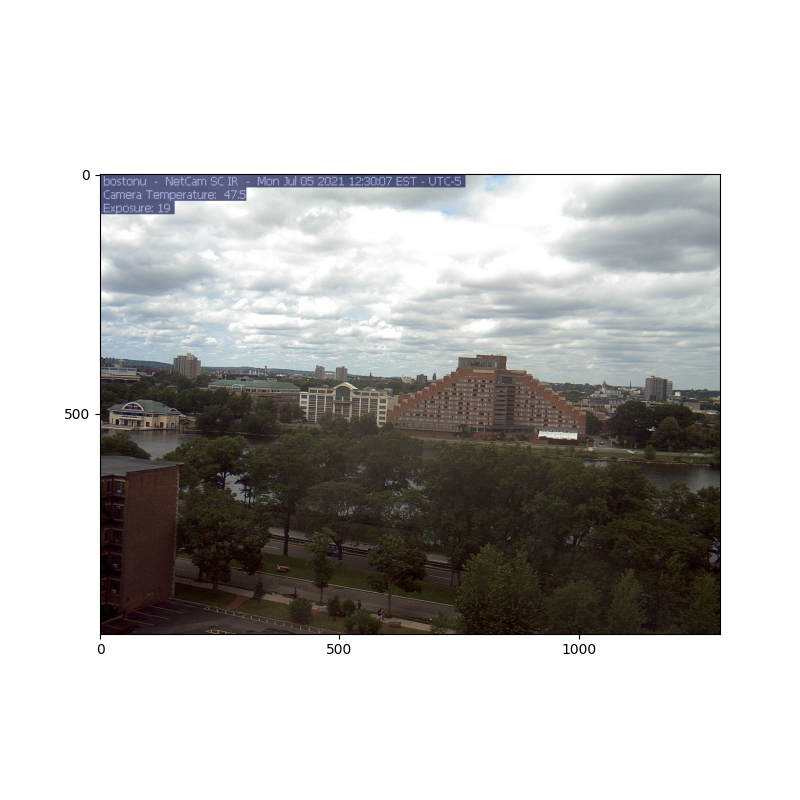

In [26]:
show_image(sample_image, foreground_points)

In [19]:
with open(f'{IMAGE_FOLDER}/points_prompt.pkl', 'wb') as f:
    pickle.dump(foreground_points, f)

# Model Initialization

In [20]:
sm = SAM(model_type=SAM_MODEL_TYPE, checkpoint=SAM_CHECKPOINT, device='cuda')

In [21]:
od = GroundingDINO(device="cuda")

final text_encoder_type: bert-base-uncased


# Vegetation Phenology Analysis

### Prompting Strategies Trade-offs
1.   Text prompting
> *   Best suited for cases where discrete items of interest (e.g. Several trees in an urban environment)
> *   Less sensitive to shifts in the field of view (e.g. Hand-held photography)
> *   Less sensitive to changes in vegetated area (e.g. Deciduous trees losing leafs in the winter)
> *   Requires not manual input, but lacks fine grained control (e.g. Can only select all forested areas)

2.   Point prompting
> *   Best suited for cases where majority of scene is the item of interest (eg. Forested environments)
> *   Sensitive to shifts in the field of view, especially when there are discrete items. Best suited for true fix-point photography (e.g Tripod mounted cameras)
> *   Sensitive to changes in vegetated area, especially when combined with shifts in field of view. Best suited for for vegetation types which don't change sizes seasonally (e.g. Coniferous trees)
> *   Offers fine grained control of exact items of interest, but requires manual input (e.g. Can select a single group of trees)



Processing 69 images: Processing image 68 - /content/phenocam/bostonu/2023/10/bostonu_2023_10_01_123007.jpg


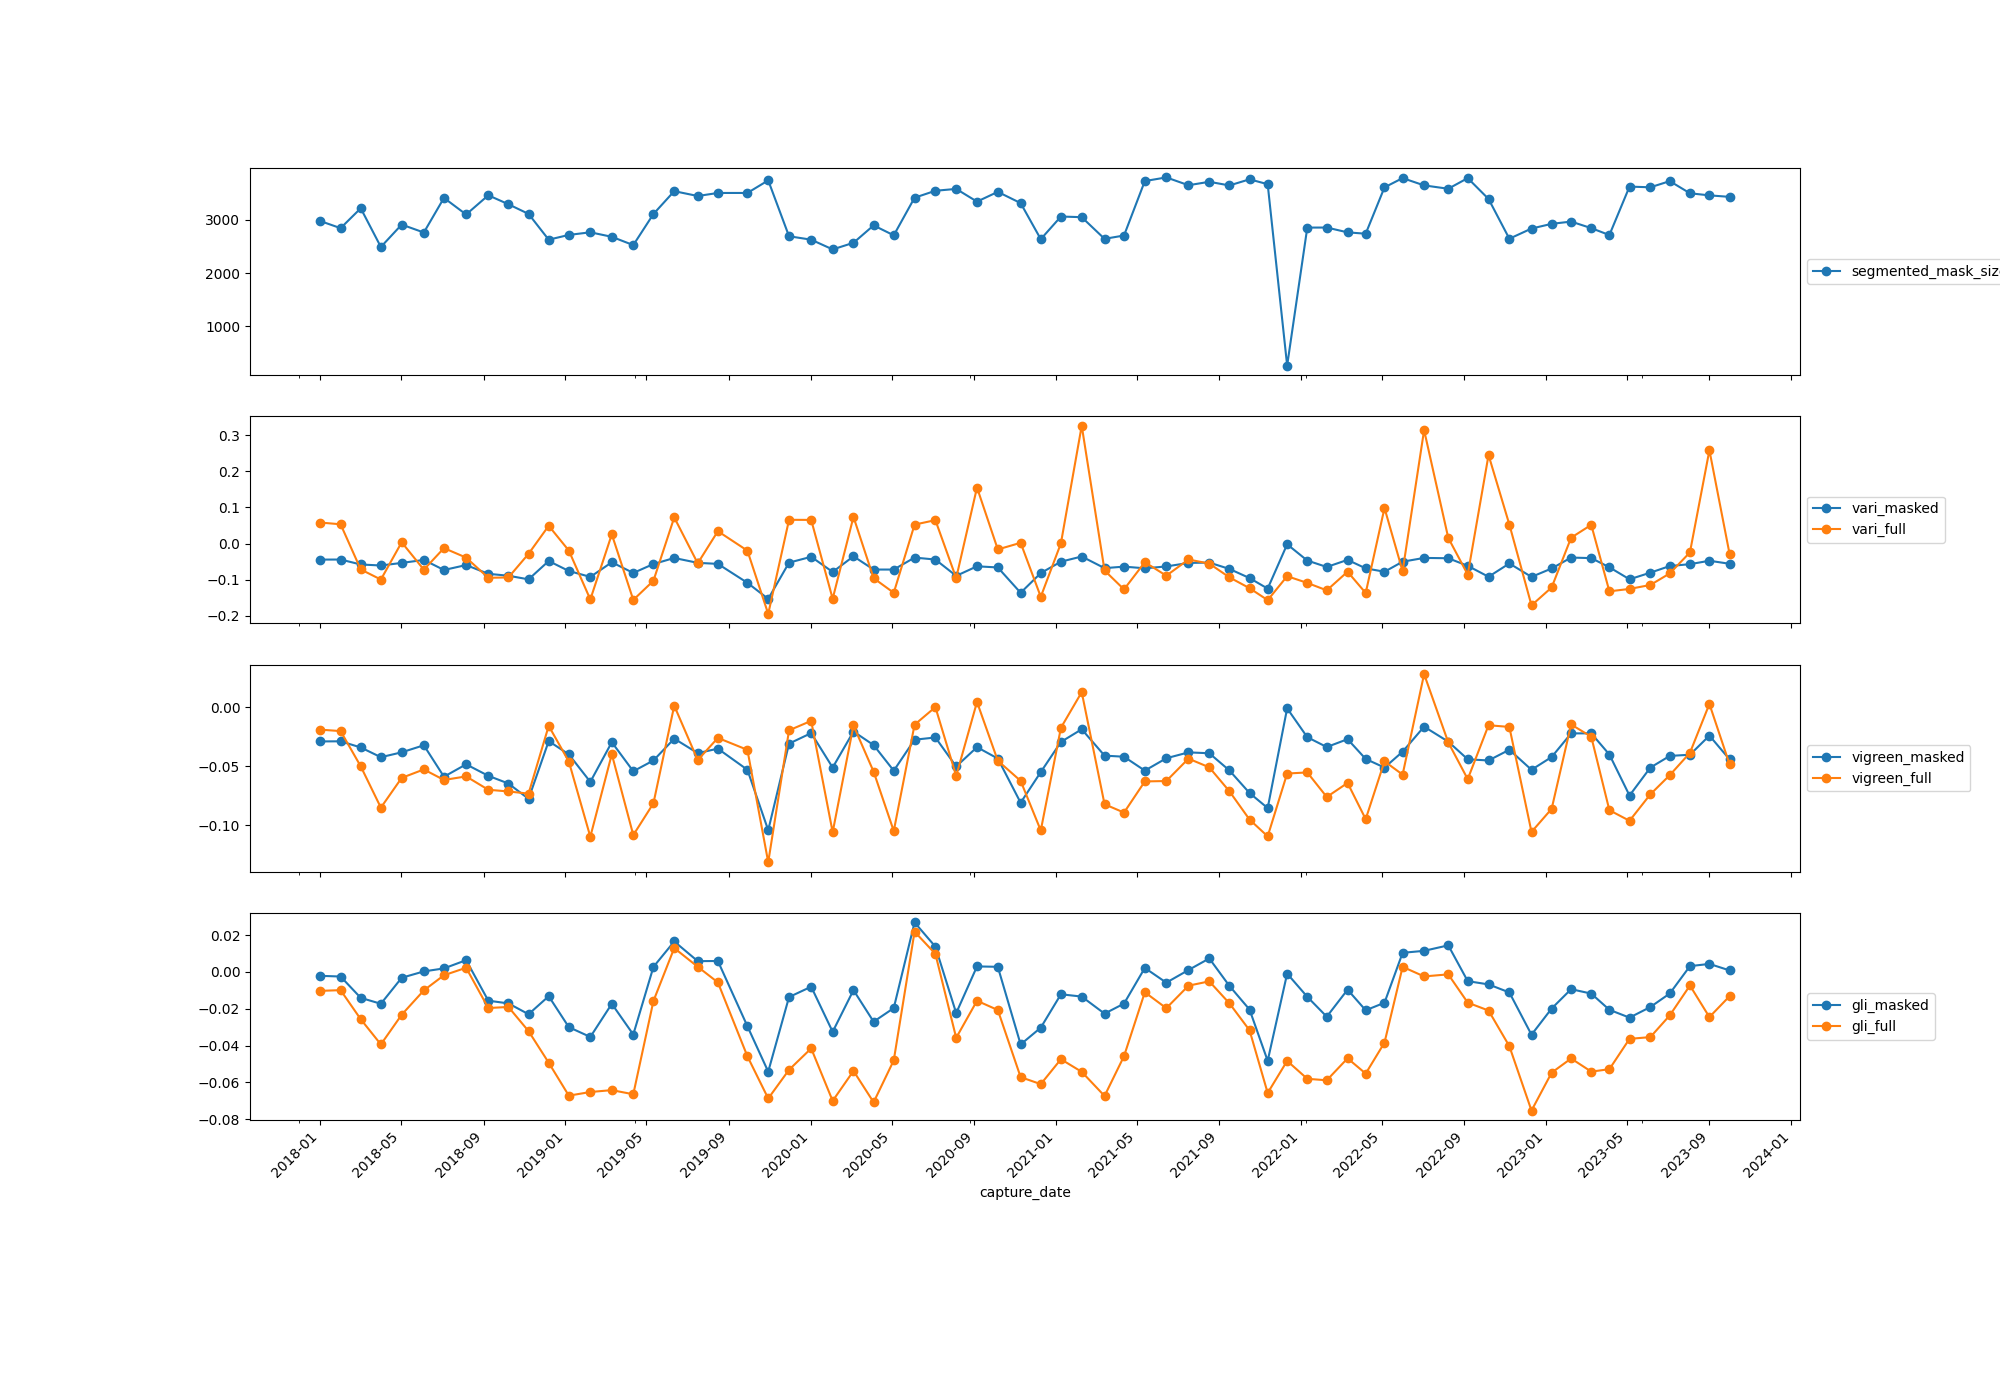

In [22]:
# Text prompted vegetation phenology
save_path, n_images_processed = process_image_timeseries(folder_path=IMAGE_FOLDER, prompting_strategy='text', text_prompt=TEXT_PROMPT, every_n=SAMPLE_EVERY_N, verbose=0)

# Only display gif result directly if limited size to avoid crashing Colab
if n_images_processed < 30:
  with open(f"{save_path}/gif/output.gif",'rb') as f:
    display.Image(data=f.read(), format='png')

  with open(f"{save_path}/gif/timeseries.gif",'rb') as f:
    display.Image(data=f.read(), format='png')
else:
  with open(f"{save_path}/csv/timeseries.png",'rb') as f:
    display.Image(data=f.read(), format='png')


Processing 69 images: Processing image 68 - /content/phenocam/bostonu/2023/10/bostonu_2023_10_01_123007.jpg


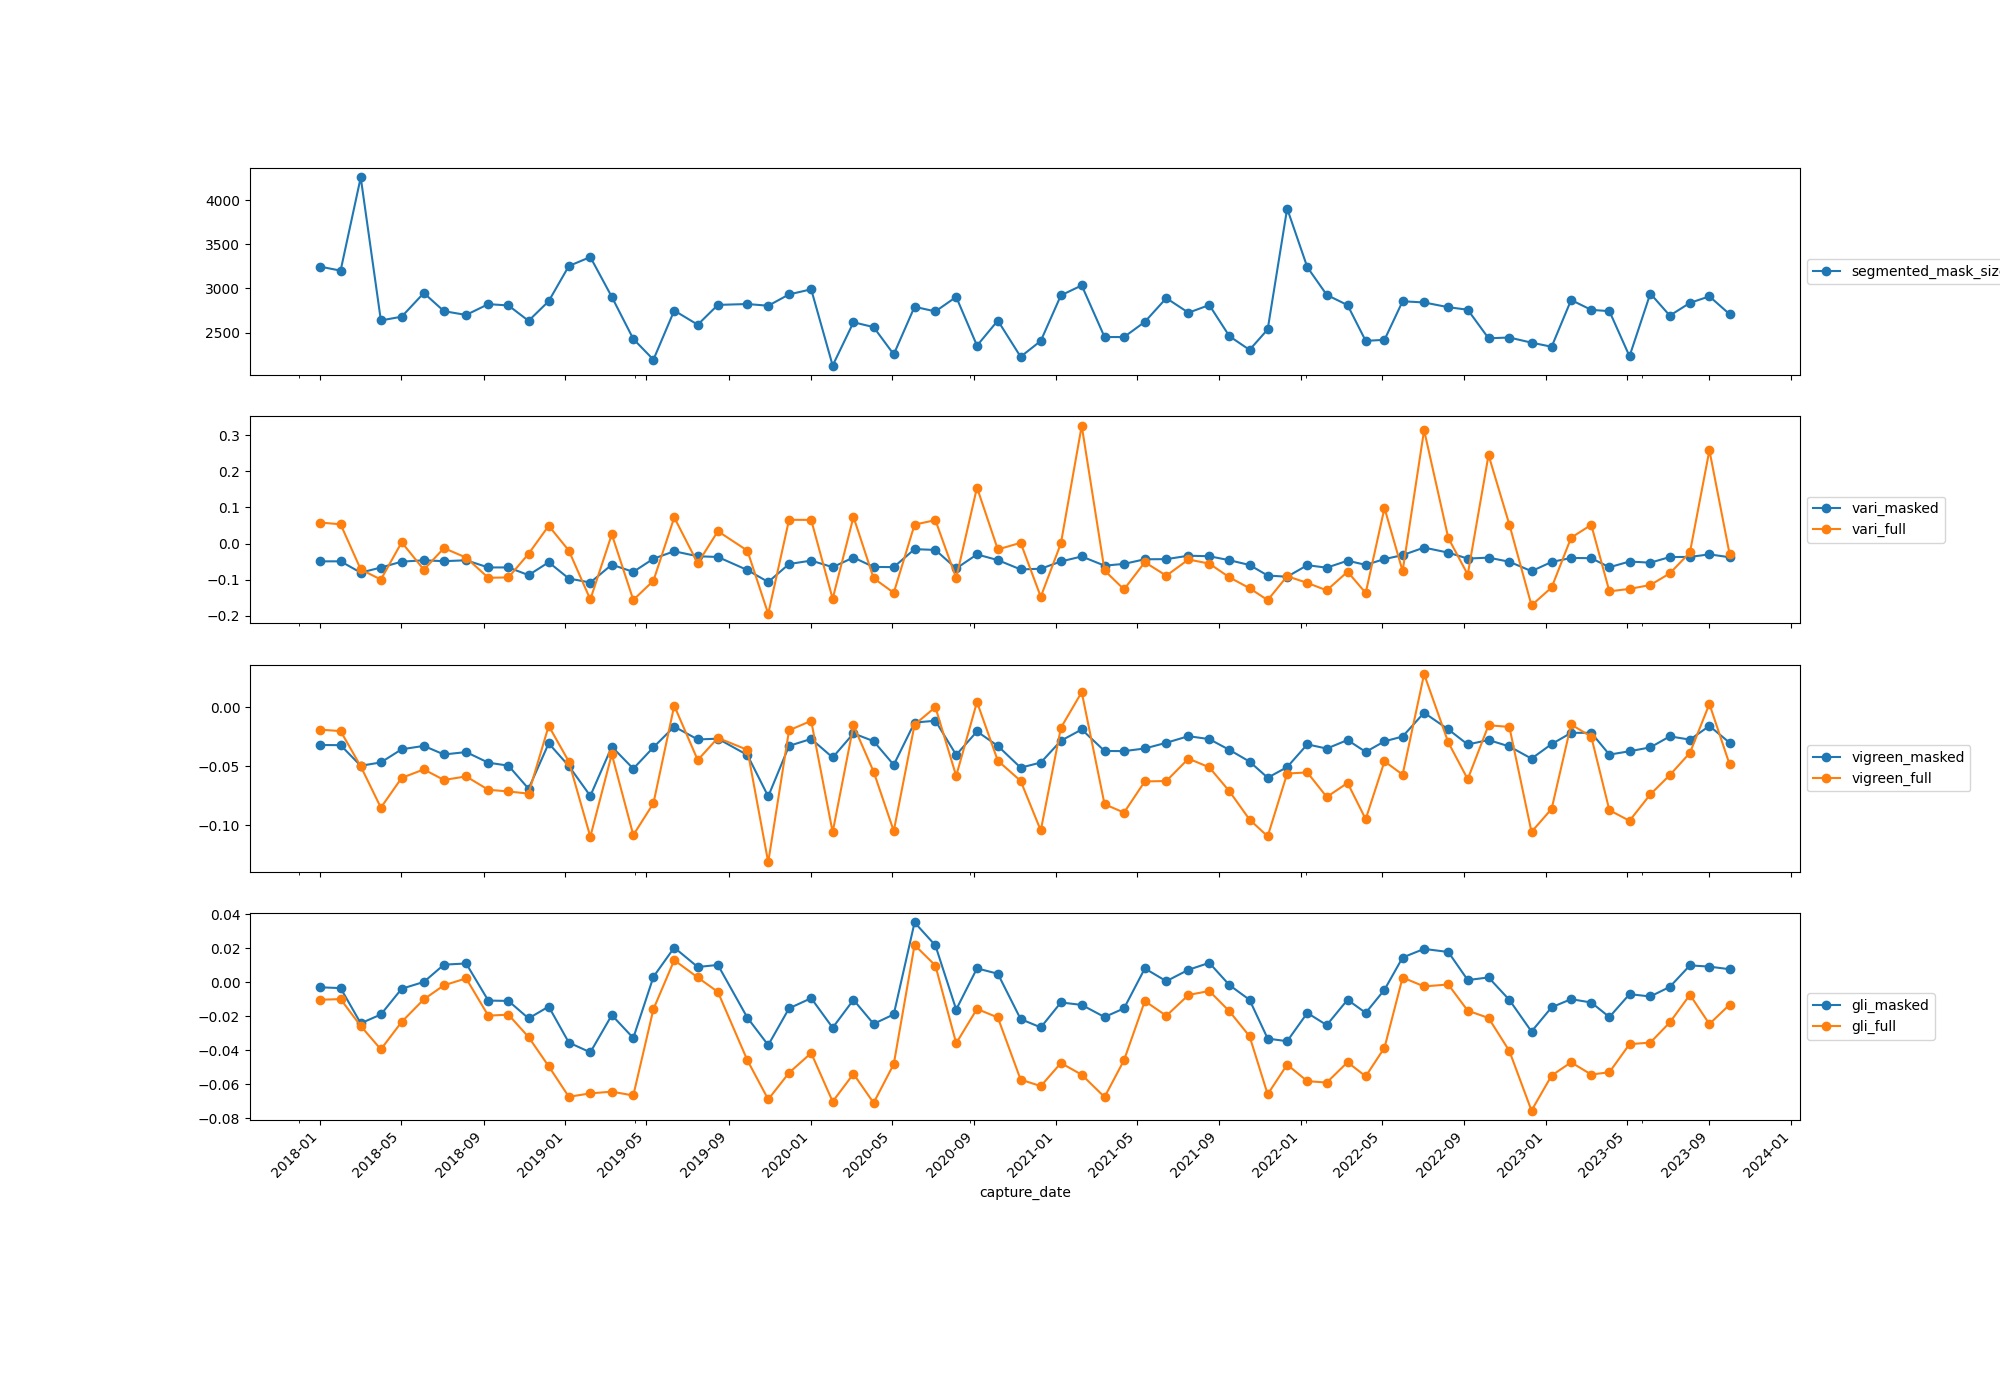

In [23]:
# Point prompted vegetation phenology
save_path, n_images_processed = process_image_timeseries(folder_path=IMAGE_FOLDER, prompting_strategy='points', text_prompt=None, every_n=SAMPLE_EVERY_N, verbose=0)

# Only display gif result directly if limited size to avoid crashing Colab
if n_images_processed < 30:
  with open(f"{save_path}/gif/output.gif",'rb') as f:
    display.Image(data=f.read(), format='png')

  with open(f"{save_path}/gif/timeseries.gif",'rb') as f:
    display.Image(data=f.read(), format='png')
else:
  with open(f"{save_path}/csv/timeseries.png",'rb') as f:
    display.Image(data=f.read(), format='png')